In [411]:
import os
from time import time
from timeit import timeit, Timer
import numpy as np
from numpy import pi, sin, log, exp
from numpy.fft import rfft
#from pyfftw.builders import rfft
from scipy.interpolate import interp1d
from scipy.special import gamma
from scipy.integrate import quad
import matplotlib.pyplot as plt

In [424]:
mu = {
    0: { 0: 1., 2: 0., 4: 0. },
    2: { 0: 1./3., 2: 2./3., 4: 0. },
    4: { 0: 1./5., 2: 4./7., 4: 8./35. },
    6: { 0: 1./7., 2: 10./21., 4: 24./77. },
    8: { 0: 1./9., 2: 40./99., 4: 48./148. }
}

M13b = {
    0: lambda n1: 1.125,
    1: lambda n1: -(1/(1 + n1)),
    2: lambda n1: 2.25,
    3: lambda n1: (3*(-1 + 3*n1))/(4.*(1 + n1)),
    4: lambda n1: -(1/(1 + n1)),
    5: lambda n1: -9/(4 + 4*n1),
    6: lambda n1: (9 + 18*n1)/(4 + 4*n1),
    7: lambda n1: (3*(-5 + 3*n1))/(8.*(1 + n1)),
    8: lambda n1: -9/(4 + 4*n1),
    9: lambda n1: (9*n1)/(4 + 4*n1),
}

def M13a(n1):
    return np.tan(n1*np.pi)/(14.*(-3 + n1)*(-2 + n1)*(-1 + n1)*n1*np.pi)

M22b = {
    0: lambda n1, n2: (6 + n1**4*(4 - 24*n2) - 7*n2 + 8*n1**5*n2 - 13*n2**2 + 4*n2**3 + 4*n2**4 + n1**2*(-13 + 38*n2 + 12*n2**2 - 8*n2**3) + 2*n1**3*(2 - 5*n2 - 4*n2**2 + 8*n2**3) + n1*(-7 - 6*n2 + 38*n2**2 - 10*n2**3 - 24*n2**4 + 8*n2**5))/(4.*n1*(1 + n1)*(-1 + 2*n1)*n2*(1 + n2)*(-1 + 2*n2)),
    1: lambda n1, n2: (-18 + n1**2*(1 - 11*n2) - 12*n2 + n2**2 + 10*n2**3 + 2*n1**3*(5 + 7*n2) + n1*(-12 - 38*n2 - 11*n2**2 + 14*n2**3))/(7.*n1*(1 + n1)*n2*(1 + n2)),
    2: lambda n1, n2: (-3*n1 + 2*n1**2 + n2*(-3 + 2*n2))/(n1*n2),
    3: lambda n1, n2: (-4*(-24 + n2 + 10*n2**2) + 2*n1*(-2 + 51*n2 + 21*n2**2) + n1**2*(-40 + 42*n2 + 98*n2**2))/(49.*n1*(1 + n1)*n2*(1 + n2)),
    4: lambda n1, n2: (4*(3 - 2*n2 + n1*(-2 + 7*n2)))/(7.*n1*n2),
    5: lambda n1, n2: 2,
    6: lambda n1, n2: ((-3 + 2*n1 + 2*n2)*(-2 + 3*n2 + 4*n1**4*n2 + 3*n2**2 - 2*n2**3 + n1**3*(-2 - 2*n2 + 4*n2**2) + n1**2*(3 - 10*n2 - 4*n2**2 + 4*n2**3) + n1*(3 + 2*n2 - 10*n2**2 - 2*n2**3 + 4*n2**4)))/(2.*n1*(1 + n1)*(-1 + 2*n1)*n2*(1 + n2)*(-1 + 2*n2)),
    7: lambda n1, n2: ((-3 + 2*n1 + 2*n2)*(2 + 4*n2 + 5*n2**2 + n1**2*(5 + 7*n2) + n1*(4 + 10*n2 + 7*n2**2)))/(7.*n1*(1 + n1)*n2*(1 + n2)),
    8: lambda n1, n2: ((n1 + n2)*(-3 + 2*n1 + 2*n2))/(n1*n2),
    9: lambda n1, n2: ((-3 + 2*n1 + 2*n2)*(10 - 23*n2 + 28*n1**4*n2 + 5*n2**2 + 2*n2**3 + n1**3*(2 - 46*n2 + 28*n2**2) + n1**2*(5 - 38*n2 - 28*n2**2 + 28*n2**3) + n1*(-23 + 94*n2 - 38*n2**2 - 46*n2**3 + 28*n2**4)))/(14.*n1*(1 + n1)*(-1 + 2*n1)*n2*(1 + n2)*(-1 + 2*n2)),
    10: lambda n1, n2: ((-3 + 2*n1 + 2*n2)*(-58 + 4*n2 + 35*n2**2 + 7*n1**2*(5 + 7*n2) + n1*(4 + 14*n2 + 49*n2**2)))/(49.*n1*(1 + n1)*n2*(1 + n2)),
    11: lambda n1, n2: ((-3 + 2*n1 + 2*n2)*(-8 + 7*n1 + 7*n2))/(7.*n1*n2),
    12: lambda n1, n2: ((-3 + 2*n1 + 2*n2)*(-1 + 2*n1 + 2*n2)*(2 + 2*n1**3 - n2 - n2**2 + 2*n2**3 - n1**2*(1 + 2*n2) - n1*(1 + 2*n2 + 2*n2**2)))/(8.*n1*(1 + n1)*(-1 + 2*n1)*n2*(1 + n2)*(-1 + 2*n2)),
    13: lambda n1, n2: ((1 + n1 + n2)*(2 + n1 + n2)*(-3 + 2*n1 + 2*n2)*(-1 + 2*n1 + 2*n2))/(8.*n1*(1 + n1)*n2*(1 + n2)),
    14: lambda n1, n2: -((-3 + 2*n1 + 2*n2)*(-6 - n1 + 2*n1**2 - n2 + 2*n2**2))/(8.*n1*(1 + n1)*n2*(1 + n2)),
    15: lambda n1, n2: ((-3 + 2*n1 + 2*n2)*(-1 + 2*n1 + 2*n2)*(38 + 41*n2 + 112*n1**3*n2 - 66*n2**2 + 2*n1**2*(-33 - 18*n2 + 56*n2**2) + n1*(41 - 232*n2 - 36*n2**2 + 112*n2**3)))/(56.*n1*(1 + n1)*(-1 + 2*n1)*n2*(1 + n2)*(-1 + 2*n2)),
    16: lambda n1, n2: -((-3 + 2*n1 + 2*n2)*(9 + 3*n1 + 3*n2 + 7*n1*n2))/(14.*n1*(1 + n1)*n2*(1 + n2)),
    17: lambda n1, n2: ((-3 + 2*n1 + 2*n2)*(-1 + 2*n1 + 2*n2)*(5 + 5*n1 + 5*n2 + 7*n1*n2))/(14.*n1*(1 + n1)*n2*(1 + n2)),
    18: lambda n1, n2: (3 - 2*n1 - 2*n2)/(2.*n1*n2),
    19: lambda n1, n2: ((-3 + 2*n1 + 2*n2)*(-1 + 2*n1 + 2*n2))/(2.*n1*n2),
    20: lambda n1, n2: ((-3 + 2*n1 + 2*n2)*(-1 + 2*n1 + 2*n2)*(50 - 9*n2 + 98*n1**3*n2 - 35*n2**2 + 7*n1**2*(-5 - 18*n2 + 28*n2**2) + n1*(-9 - 66*n2 - 126*n2**2 + 98*n2**3)))/(196.*n1*(1 + n1)*(-1 + 2*n1)*n2*(1 + n2)*(-1 + 2*n2)),
    21: lambda n1, n2: ((-3 + 2*n1 + 2*n2)*(-1 + 2*n1 + 2*n2)*(2 + n1 + 4*n1**3 + n2 - 8*n1*n2 - 8*n1**2*n2 - 8*n1*n2**2 + 4*n2**3))/(8.*n1*(1 + n1)*(-1 + 2*n1)*n2*(1 + n2)*(-1 + 2*n2)),
    22: lambda n1, n2: ((2 + n1 + n2)*(-3 + 2*n1 + 2*n2)*(-1 + 2*n1 + 2*n2)*(1 + 2*n1 + 2*n2))/(8.*n1*(1 + n1)*n2*(1 + n2)),
    23: lambda n1, n2: -((-3 + 2*n1 + 2*n2)*(-1 + 2*n1 + 2*n2)*(-2 + 7*n1 + 7*n2))/(56.*n1*(1 + n1)*n2*(1 + n2)),
    24: lambda n1, n2: ((-3 + 2*n1 + 2*n2)*(-1 + 2*n1 + 2*n2)*(26 + 9*n2 + 56*n1**3*n2 - 38*n2**2 + 2*n1**2*(-19 - 18*n2 + 56*n2**2) + n1*(9 - 84*n2 - 36*n2**2 + 56*n2**3)))/(56.*n1*(1 + n1)*(-1 + 2*n1)*n2*(1 + n2)*(-1 + 2*n2)),
    25: lambda n1, n2: (3*(-3 + 2*n1 + 2*n2)*(-1 + 2*n1 + 2*n2))/(32.*n1*(1 + n1)*n2*(1 + n2)),
    26: lambda n1, n2: ((-3 + 2*n1 + 2*n2)*(-1 + 2*n1 + 2*n2)*(1 + 2*n1 + 2*n2)*(1 + 2*n1**2 - 8*n1*n2 + 2*n2**2))/(16.*n1*(1 + n1)*(-1 + 2*n1)*n2*(1 + n2)*(-1 + 2*n2)),
    27: lambda n1, n2: ((-3 + 2*n1 + 2*n2)*(-1 + 2*n1 + 2*n2)*(1 + 2*n1 + 2*n2)*(3 + 2*n1 + 2*n2))/(32.*n1*(1 + n1)*n2*(1 + n2)),
}

def M22a(n1, n2):
    return (gamma(1.5 - n1)*gamma(1.5 - n2)*gamma(-1.5 + n1 + n2))/(8.*np.pi**1.5*gamma(n1)*gamma(3 - n1 - n2)*gamma(n2))

### matrix for spherical bessel transform from Power spectrum to Correlation function
def MPC(l, pn):
    return np.pi**-1.5 * 2.**(-2.*pn) * gamma(1.5+l/2.-pn) / gamma(l/2.+pn)

def cH(Om,a):
    return np.sqrt(Om/a+a**2*(1-Om))
def DgN(Om,a):
    return 5./2*Om*cH(Om,a)/a*quad(lambda x:cH(Om,x)**-3,0,a)[0]
def fN(Om,z):
    a = 1./(1.+z)
    return (Om*(5*a - 3*DgN(Om,a)))/(2.*(a**3*(1 - Om) + Om)*DgN(Om,a))

In [523]:
Q100 = {
    0: lambda f: 0,
    1: lambda f: (-15 - 20*f - 22*f**2 - 12*f**3 - 3*f**4)/120.,
    2: lambda f: (35 + 70*f + 119*f**2 + 124*f**3 + 81*f**4 + 30*f**5 + 5*f**6)/840.,
    3: lambda f: (-945 - 2520*f - 5796*f**2 - 8856*f**3 - 9854*f**4 - 7720*f**5 - 3900*f**6 - 1120*f**7 - 140*f**8)/120960.,
    4: lambda f: 0,
    5: lambda f: 0,
    6: lambda f: 0,
    7: lambda f: 0,
    8: lambda f: 0,
    9: lambda f: 0,
    10: lambda f: 0,
    11: lambda f: 0,
    12: lambda f: 0,
    13: lambda f: (-15 + 2*f**2 - 3*f**4)/180.,
    14: lambda f: (105 + 70*f + 21*f**2 - 36*f**3 + 3*f**4 + 30*f**5 + 15*f**6)/2520.,
    15: lambda f: (-315 - 420*f - 420*f**2 - 36*f**3 + 182*f**4 + 20*f**5 - 180*f**6 - 140*f**7 - 35*f**8)/30240.,
    16: lambda f: 0,
    17: lambda f: (105 - 35*f**2 - 18*f**3 + 12*f**4)/630.,
    18: lambda f: (-105 - 70*f + 72*f**3 + 35*f**4 - 10*f**5 - 10*f**6)/1260.,
    19: lambda f: (3465 + 4620*f + 3927*f**2 - 1386*f**3 - 4873*f**4 - 3040*f**5 + 225*f**6 + 910*f**7 + 280*f**8)/166320.,
    20: lambda f: 0,
    21: lambda f: 0,
    22: lambda f: 0,
    23: lambda f: 0,
    24: lambda f: 0,
    25: lambda f: 0,
    26: lambda f: 0,
    27: lambda f: 0,
    28: lambda f: 0
}

Q102 = {
    0: lambda f: 0,
    1: lambda f: 0,
    2: lambda f: 0,
    3: lambda f: 0,
    4: lambda f: 0,
    5: lambda f: -(f*(14 + 19*f + 12*f**2 + 3*f**3))/210.,
    6: lambda f: (f*(42 + 93*f + 112*f**2 + 78*f**3 + 30*f**4 + 5*f**5))/1260.,
    7: lambda f: -(f*(1386 + 4257*f + 7524*f**2 + 9071*f**3 + 7450*f**4 + 3855*f**5 + 1120*f**6 + 140*f**7))/166320.,
    8: lambda f: 0,
    9: lambda f: 0,
    10: lambda f: 0,
    11: lambda f: 0,
    12: lambda f: 0,
    13: lambda f: (f*(-350 - 159*f + 36*f**2 + 84*f**3))/12600.,
    14: lambda f: (f*(210 + 289*f + 184*f**2 - 29*f**3 - 80*f**4 - 30*f**5))/12600.,
    15: lambda f: (f*(-16170 - 36861*f - 46596*f**2 - 27034*f**3 + 1370*f**4 + 12675*f**5 + 7420*f**6 + 1540*f**7))/3.3264e6,
    16: lambda f: 0,
    17: lambda f: (f*(-98 + 273*f + 72*f**2 - 132*f**3))/8820.,
    18: lambda f: (f*(294 + 70*f - 212*f**2 - 103*f**3 + 80*f**4 + 55*f**5))/8820.,
    19: lambda f: -(f*(35574 + 45969*f + 11352*f**2 - 26882*f**3 - 18950*f**4 + 6585*f**5 + 10640*f**6 + 3080*f**7))/2.32848e6,
    20: lambda f: 0,
    21: lambda f: (f*(490 - 259*f - 124*f**2 + 64*f**3))/29400.,
    22: lambda f: -(f*(5390 + 1771*f - 2904*f**2 - 2381*f**3 + 380*f**4 + 480*f**5))/323400.,
    23: lambda f: (f*(210210 + 249249*f + 26884*f**2 - 218634*f**3 - 171330*f**4 - 5575*f**5 + 42420*f**6 + 13440*f**7))/3.36336e7,
    24: lambda f: (f*(182 + 19*f - 36*f**2))/840.,
    25: lambda f: (f*(-182 - 175*f - 40*f**2 + 41*f**3 + 20*f**4))/840.,
    26: lambda f: (f*(6006 + 10923*f + 9548*f**2 + 2514*f**3 - 2070*f**4 - 1805*f**5 - 420*f**6))/73920.,
    27: lambda f: (f*(-78078 - 208923*f - 305448*f**2 - 245453*f**3 - 73810*f**4 + 49395*f**5 + 59780*f**6 + 24325*f**7 + 3780*f**8))/4.32432e6,
    28: lambda f: 0
}

Q120 = {
    0: lambda f: 0,
    1: lambda f: -(f*(14 + 19*f + 12*f**2 + 3*f**3))/42.,
    2: lambda f: (f*(42 + 93*f + 112*f**2 + 78*f**3 + 30*f**4 + 5*f**5))/252.,
    3: lambda f: -(f*(1386 + 4257*f + 7524*f**2 + 9071*f**3 + 7450*f**4 + 3855*f**5 + 1120*f**6 + 140*f**7))/33264.,
    4: lambda f: 0,
    5: lambda f: 0,
    6: lambda f: 0,
    7: lambda f: 0,
    8: lambda f: 0,
    9: lambda f: 0,
    10: lambda f: 0,
    11: lambda f: 0,
    12: lambda f: 0,
    13: lambda f: (5*f**2 - 3*f**4)/63.,
    14: lambda f: (f*(14 - 3*f - 16*f**2 - 2*f**3 + 10*f**4 + 5*f**5))/252.,
    15: lambda f: -(f*(231 + 231*f - 66*f**2 - 263*f**3 - 65*f**4 + 165*f**5 + 140*f**6 + 35*f**7))/8316.,
    16: lambda f: 0,
    17: lambda f: (f**2*(-23 - 6*f + 9*f**2))/126.,
    18: lambda f: (f*(-308 + 99*f + 484*f**2 + 210*f**3 - 120*f**4 - 85*f**5))/2772.,
    19: lambda f: (f*(24024 + 22737*f - 14586*f**2 - 42913*f**3 - 24340*f**4 + 5415*f**5 + 10150*f**6 + 2905*f**7))/432432.,
    20: lambda f: 0,
    21: lambda f: 0,
    22: lambda f: 0,
    23: lambda f: 0,
    24: lambda f: 0,
    25: lambda f: 0,
    26: lambda f: 0,
    27: lambda f: 0,
    28: lambda f: 0
}

Q122 = {
    0: lambda f: 0,
    1: lambda f: 0,
    2: lambda f: 0,
    3: lambda f: 0,
    4: lambda f: 0,
    5: lambda f: (-21 - 44*f - 58*f**2 - 36*f**3 - 9*f**4)/168.,
    6: lambda f: (231 + 726*f + 1551*f**2 + 1868*f**3 + 1317*f**4 + 510*f**5 + 85*f**6)/5544.,
    7: lambda f: (-27027 - 113256*f - 334620*f**2 - 596232*f**3 - 732778*f**4 - 610520*f**5 - 318660*f**6 - 92960*f**7 - 11620*f**8)/3.459456e6,
    8: lambda f: 0,
    9: lambda f: 0,
    10: lambda f: 0,
    11: lambda f: 0,
    12: lambda f: 0,
    13: lambda f: (-105 - 226*f - 159*f**2 + 84*f**3 + 96*f**4)/5040.,
    14: lambda f: (1155 + 3696*f + 6710*f**2 + 3892*f**3 - 1377*f**4 - 2580*f**5 - 880*f**6)/110880.,
    15: lambda f: (-45045 - 191334*f - 532389*f**2 - 696072*f**3 - 395423*f**4 + 84250*f**5 + 260265*f**6 + 145460*f**7 + 29120*f**8)/1.729728e7,
    16: lambda f: 0,
    17: lambda f: (-735 - 154*f + 381*f**2 + 108*f**3 - 198*f**4)/3528.,
    18: lambda f: (8085 + 10164*f + 2816*f**2 - 7556*f**3 - 3739*f**4 + 2720*f**5 + 1870*f**6)/77616.,
    19: lambda f: (-315315 - 726726*f - 923637*f**2 - 183144*f**3 + 601429*f**4 + 426490*f**5 - 125655*f**6 - 220780*f**7 - 63910*f**8)/1.2108096e7,
    20: lambda f: 0,
    21: lambda f: (8085 + 154*f - 6589*f**2 - 2116*f**3 + 2176*f**4)/129360.,
    22: lambda f: (-105105 - 112112*f + 18590*f**2 + 173316*f**3 + 85499*f**4 - 36740*f**5 - 27840*f**6)/3.36336e6,
    23: lambda f: (105105 + 222222*f + 228657*f**2 - 128024*f**3 - 418221*f**4 - 254130*f**5 + 39035*f**6 + 93660*f**7 + 26880*f**8)/1.345344e7,
    24: lambda f: (273 + 178*f - 25*f**2 - 84*f**3)/336.,
    25: lambda f: (-3003 - 5104*f - 4598*f**2 - 20*f**3 + 1993*f**4 + 820*f**5)/7392.,
    26: lambda f: (39039 + 107250*f + 190047*f**2 + 151736*f**3 + 17373*f**4 - 61710*f**5 - 43595*f**6 - 9660*f**7)/384384.,
    27: lambda f: (-117117 - 444444*f - 1161732*f**2 - 1672008*f**3 - 1279078*f**4 - 236480*f**5 + 463500*f**6 + 448840*f**7 + 173915*f**8 + 26460*f**9)/6.918912e6,
    28: lambda f: 0,
}

Q000 = {
    0: lambda f: (-3 - 2*f - f**2)/6.,
    1: lambda f: (15 + 20*f + 22*f**2 + 12*f**3 + 3*f**4)/120.,
    2: lambda f: (-35 - 70*f - 119*f**2 - 124*f**3 - 81*f**4 - 30*f**5 - 5*f**6)/1680.,
    3: lambda f: (105 + 280*f + 644*f**2 + 984*f**3 + 846*f**4 + 360*f**5 + 60*f**6)/40320.,
    4: lambda f: 0,
    5: lambda f: 0,
    6: lambda f: 0,
    7: lambda f: 0,
    8: lambda f: 0,
    9: lambda f: 0,
    10: lambda f: 0,
    11: lambda f: 0,
    12: lambda f: (-3 + 2*f - f**2)/18.,
    13: lambda f: (15 - 2*f**2 + 3*f**4)/180.,
    14: lambda f: (-105 - 70*f - 21*f**2 + 36*f**3 - 3*f**4 - 30*f**5 - 15*f**6)/5040.,
    15: lambda f: (315 + 420*f + 420*f**2 + 36*f**3 - 182*f**4 - 20*f**5 + 180*f**6 + 140*f**7 + 35*f**8)/90720.,
    16: lambda f: (15 - 10*f + 2*f**2)/45.,
    17: lambda f: (-105 + 35*f**2 + 18*f**3 - 12*f**4)/630.,
    18: lambda f: (105 + 70*f - 72*f**3 - 35*f**4 + 10*f**5 + 10*f**6)/2520.,
    19: lambda f: (-3465 - 4620*f - 3927*f**2 + 1386*f**3 + 4873*f**4 + 3040*f**5 - 225*f**6 - 910*f**7 - 280*f**8)/498960.,
    20: lambda f: 0,
    21: lambda f: 0,
    22: lambda f: 0,
    23: lambda f: 0,
    24: lambda f: 0,
    25: lambda f: 0,
    26: lambda f: 0,
    27: lambda f: 0,
    28: lambda f: 0
}

Q002 = {
    0: lambda f: 0,
    1: lambda f: 0,
    2: lambda f: 0,
    3: lambda f: 0,
    4: lambda f: -(f*(2 + f))/15.,
    5: lambda f: (f*(14 + 19*f + 12*f**2 + 3*f**3))/210.,
    6: lambda f: -(f*(42 + 93*f + 112*f**2 + 78*f**3 + 30*f**4 + 5*f**5))/2520.,
    7: lambda f: (f*(14 + 43*f + 76*f**2 + 69*f**3 + 30*f**4 + 5*f**5))/5040.,
    8: lambda f: 0,
    9: lambda f: 0,
    10: lambda f: 0,
    11: lambda f: 0,
    12: lambda f: ((-2 + f)*f)/45.,
    13: lambda f: (f*(350 + 159*f - 36*f**2 - 84*f**3))/12600.,
    14: lambda f: (f*(-210 - 289*f - 184*f**2 + 29*f**3 + 80*f**4 + 30*f**5))/25200.,
    15: lambda f: (f*(16170 + 36861*f + 46596*f**2 + 27034*f**3 - 1370*f**4 - 12675*f**5 - 7420*f**6 - 1540*f**7))/9.9792e6,
    16: lambda f: ((28 - 11*f)*f)/315.,
    17: lambda f: (f*(98 - 273*f - 72*f**2 + 132*f**3))/8820.,
    18: lambda f: -(f*(294 + 70*f - 212*f**2 - 103*f**3 + 80*f**4 + 55*f**5))/17640.,
    19: lambda f: (f*(35574 + 45969*f + 11352*f**2 - 26882*f**3 - 18950*f**4 + 6585*f**5 + 10640*f**6 + 3080*f**7))/6.98544e6,
    20: lambda f: 0,
    21: lambda f: (f*(-490 + 259*f + 124*f**2 - 64*f**3))/29400.,
    22: lambda f: (f*(5390 + 1771*f - 2904*f**2 - 2381*f**3 + 380*f**4 + 480*f**5))/646800.,
    23: lambda f: -(f*(210210 + 249249*f + 26884*f**2 - 218634*f**3 - 171330*f**4 - 5575*f**5 + 42420*f**6 + 13440*f**7))/1.009008e8,
    24: lambda f: (f*(-182 - 19*f + 36*f**2))/840.,
    25: lambda f: (f*(182 + 175*f + 40*f**2 - 41*f**3 - 20*f**4))/1680.,
    26: lambda f: (f*(-6006 - 10923*f - 9548*f**2 - 2514*f**3 + 2070*f**4 + 1805*f**5 + 420*f**6))/221760.,
    27: lambda f: (f*(2002 + 5357*f + 7832*f**2 + 3867*f**3 - 1410*f**4 - 1805*f**5 - 420*f**6))/443520.,
    28: lambda f: 0
}

Q020 = {
    0: lambda f: -(f*(2 + f))/3.,
    1: lambda f: (f*(14 + 19*f + 12*f**2 + 3*f**3))/42.,
    2: lambda f: -(f*(42 + 93*f + 112*f**2 + 78*f**3 + 30*f**4 + 5*f**5))/504.,
    3: lambda f: (f*(14 + 43*f + 76*f**2 + 69*f**3 + 30*f**4 + 5*f**5))/1008.,
    4: lambda f: 0,
    5: lambda f: 0,
    6: lambda f: 0,
    7: lambda f: 0,
    8: lambda f: 0,
    9: lambda f: 0,
    10: lambda f: 0,
    11: lambda f: 0,
    12: lambda f: -((-2 + f)*f)/9.,
    13: lambda f: (f**2*(-5 + 3*f**2))/63.,
    14: lambda f: (f*(-14 + 3*f + 16*f**2 + 2*f**3 - 10*f**4 - 5*f**5))/504.,
    15: lambda f: (f*(231 + 231*f - 66*f**2 - 263*f**3 - 65*f**4 + 165*f**5 + 140*f**6 + 35*f**7))/24948.,
    16: lambda f: (f*(-28 + 11*f))/63.,
    17: lambda f: (f**2*(23 + 6*f - 9*f**2))/126.,
    18: lambda f: (f*(308 - 99*f - 484*f**2 - 210*f**3 + 120*f**4 + 85*f**5))/5544.,
    19: lambda f: -(f*(24024 + 22737*f - 14586*f**2 - 42913*f**3 - 24340*f**4 + 5415*f**5 + 10150*f**6 + 2905*f**7))/1.297296e6,
    20: lambda f: 0,
    21: lambda f: 0,
    22: lambda f: 0,
    23: lambda f: 0,
    24: lambda f: 0,
    25: lambda f: 0,
    26: lambda f: 0,
    27: lambda f: 0,
    28: lambda f: 0
}

Q022 = {
    0: lambda f: 0,
    1: lambda f: 0,
    2: lambda f: 0,
    3: lambda f: 0,
    4: lambda f: (-21 - 22*f - 11*f**2)/42.,
    5: lambda f: (21 + 44*f + 58*f**2 + 36*f**3 + 9*f**4)/168.,
    6: lambda f: (-231 - 726*f - 1551*f**2 - 1868*f**3 - 1317*f**4 - 510*f**5 - 85*f**6)/11088.,
    7: lambda f: (231 + 968*f + 2860*f**2 + 5096*f**3 + 4674*f**4 + 2040*f**5 + 340*f**6)/88704.,
    8: lambda f: 0,
    9: lambda f: 0,
    10: lambda f: 0,
    11: lambda f: 0,
    12: lambda f: -0.041666666666666664 - (29*f)/630. + (2*f**2)/45.,
    13: lambda f: (105 + 226*f + 159*f**2 - 84*f**3 - 96*f**4)/5040.,
    14: lambda f: (-1155 - 3696*f - 6710*f**2 - 3892*f**3 + 1377*f**4 + 2580*f**5 + 880*f**6)/221760.,
    15: lambda f: (45045 + 191334*f + 532389*f**2 + 696072*f**3 + 395423*f**4 - 84250*f**5 - 260265*f**6 - 145460*f**7 - 29120*f**8)/5.189184e7,
    16: lambda f: (-735 + 616*f - 242*f**2)/1764.,
    17: lambda f: (735 + 154*f - 381*f**2 - 108*f**3 + 198*f**4)/3528.,
    18: lambda f: (-8085 - 10164*f - 2816*f**2 + 7556*f**3 + 3739*f**4 - 2720*f**5 - 1870*f**6)/155232.,
    19: lambda f: (315315 + 726726*f + 923637*f**2 + 183144*f**3 - 601429*f**4 - 426490*f**5 + 125655*f**6 + 220780*f**7 + 63910*f**8)/3.6324288e7,
    20: lambda f: 0.125 - (9*f)/70. + (8*f**2)/245.,
    21: lambda f: (-8085 - 154*f + 6589*f**2 + 2116*f**3 - 2176*f**4)/129360.,
    22: lambda f: (105105 + 112112*f - 18590*f**2 - 173316*f**3 - 85499*f**4 + 36740*f**5 + 27840*f**6)/6.72672e6,
    23: lambda f: (-105105 - 222222*f - 228657*f**2 + 128024*f**3 + 418221*f**4 + 254130*f**5 - 39035*f**6 - 93660*f**7 - 26880*f**8)/4.036032e7,
    24: lambda f: (-273 - 178*f + 25*f**2 + 84*f**3)/336.,
    25: lambda f: (3003 + 5104*f + 4598*f**2 + 20*f**3 - 1993*f**4 - 820*f**5)/14784.,
    26: lambda f: (-39039 - 107250*f - 190047*f**2 - 151736*f**3 - 17373*f**4 + 61710*f**5 + 43595*f**6 + 9660*f**7)/1.153152e6,
    27: lambda f: (39039 + 148148*f + 387244*f**2 + 557336*f**3 + 224946*f**4 - 182880*f**5 - 174380*f**6 - 38640*f**7)/9.225216e6,
    28: lambda f: 1.625 - (9*f)/14.,
}



Qa = {
    0: {
        0: { 0: Q000, 2: Q002 },
        2: { 0: Q020, 2: Q022 }
    },
    1: {
        0: { 0: Q100, 2: Q102 },
        2: { 0: Q120, 2: Q122 }
    },
}

In [1065]:
def CoefWindow(N, window=1):
    n = np.arange(-N//2,N//2+1)
    if window is 1: n_cut = N//2
    else: n_cut = int(window*N//2.)
    
    n_right = n[-1] - n_cut
    n_left = n[0]+ n_cut 

    n_r=n[ n[:]  > n_right ] 
    n_l=n[ n[:]  <  n_left ]

    theta_right=(n[-1]-n_r)/float(n[-1]-n_right-1) 
    theta_left=(n_l - n[0])/float(n_left-n[0]-1)
    
    W=np.ones(n.size)
    W[n[:] > n_right]= theta_right - 1/(2*pi)*sin(2*pi*theta_right)
    W[n[:] < n_left]= theta_left - 1/(2*pi)*sin(2*pi*theta_left)
    
    return W

class FFTLog(object):
    def __init__(self, **kwargs):
        self.Nmax = kwargs['Nmax']
        self.xmin = kwargs['xmin']
        self.xmax = kwargs['xmax']
        self.bias = kwargs['bias']
        self.dx = np.log(self.xmax/self.xmin) / (self.Nmax-1.)
        self.setx()
        self.setPow()
    
    def setx(self):
        self.x = np.empty(self.Nmax)
        for i in range(self.Nmax): 
            self.x[i] = self.xmin * np.exp(i*self.dx)
    
    def setPow(self):
        self.Pow = np.empty(self.Nmax+1, dtype = complex)
        for i in range(self.Nmax+1): 
            self.Pow[i] = self.bias + 1j * 2.*np.pi / (self.Nmax*self.dx) * (i - self.Nmax/2.)
    
    def Coef(self, xin, f, window=1, co=common):
        
        interpfunc = interp1d(xin, f, kind='cubic')
        
        if xin[0] > self.x[0]:
            print ('low extrapolation')
            nslow = (log(f[1])-log(f[0])) / (log(xin[1])-log(xin[0]))
            Aslow = f[0] / xin[0]**nslow
        if xin[-1] < self.x[-1]:
            print ('high extrapolation')
            nshigh = (log(f[-1])-log(f[-2])) / (log(xin[-1])-log(xin[-2]))
            Ashigh = f[-1] / xin[-1]**nshigh
        
        fx = np.empty(self.Nmax)
        tmp = np.empty(int(self.Nmax/2+1), dtype = complex)
        Coef = np.empty(self.Nmax+1, dtype = complex)
        
        for i in range(self.Nmax): 
            if xin[0] > self.x[i]: fx[i] = Aslow * self.x[i]**nslow * np.exp(-self.bias*i*self.dx)
            elif xin[-1] < self.x[i]: fx[i] = Ashigh * self.x[i]**nshigh * np.exp(-self.bias*i*self.dx)
            else: fx[i] = interpfunc(self.x[i]) * np.exp(-self.bias*i*self.dx)
        
        tmp = rfft(fx)
        # tmp = rfft(fx)() ### pyfftw
        
        for i in range(self.Nmax+1):
            if (i < self.Nmax/2): Coef[i] = np.conj(tmp[int(self.Nmax/2-i)]) * self.xmin**(-self.Pow[i]) / float(self.Nmax)
            else: Coef[i] = tmp[int(i-self.Nmax/2)] * self.xmin**(-self.Pow[i]) / float(self.Nmax)
        
        if window is not None: Coef = Coef*CoefWindow(self.Nmax, window=window)
        else:
            Coef[0] /= 2.
            Coef[self.Nmax] /= 2.
        
        return Coef
        #return self.x, 
    
    def sumCoefxPow(self, xin, f, x, window=1):    
        Coef = self.Coef(xin, f, window=window)
        fFFT = np.empty_like(x)
        for i, xi in enumerate(x):
            fFFT[i] = np.real( np.sum(Coef * xi**self.Pow) )
        return fFFT

In [524]:
kout = np.array([ 0.001, 0.005, 0.0075, 0.01, 0.0125, 0.015, 0.0175, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05, 0.055, 0.06, 0.065, 0.07, 0.075, 0.08, 0.085, 0.09, 0.095, 0.1, 0.105, 0.11, 0.115, 0.12, 0.125, 0.13, 0.135, 0.14, 0.145, 0.15, 0.155, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 ])
qopti = np.array([ 5.000e+01,5.245e+01,5.490e+01,5.735e+01,5.980e+01,6.224e+01,6.469e+01,6.714e+01,6.959e+01,7.204e+01,7.449e+01,7.694e+01,7.939e+01,8.184e+01,8.429e+01,8.673e+01,8.918e+01,9.163e+01,9.408e+01,9.653e+01,9.898e+01,1.014e+02,1.039e+02,1.063e+02,1.088e+02,1.112e+02,1.137e+02,1.161e+02,1.186e+02,1.210e+02,1.235e+02,1.259e+02,1.284e+02,1.308e+02,1.333e+02,1.357e+02,1.382e+02,1.406e+02,1.431e+02,1.455e+02,1.480e+02,1.504e+02,1.529e+02,1.553e+02,1.578e+02,1.602e+02,1.627e+02,1.651e+02,1.676e+02,1.700e+02 ])
#qopti = np.array([ 1.000e+00,1.124e+00,1.264e+00,1.421e+00,1.597e+00,1.796e+00,2.019e+00,2.270e+00,2.551e+00,2.868e+00,3.225e+00,3.625e+00,4.075e+00,4.582e+00,5.151e+00,5.790e+00,6.510e+00,7.318e+00,8.227e+00,9.249e+00,1.040e+01,1.169e+01,1.314e+01,1.477e+01,1.661e+01,1.867e+01,2.099e+01,2.360e+01,2.653e+01,2.982e+01,3.353e+01,3.769e+01,4.238e+01,4.764e+01,5.356e+01,6.000e+01,6.021e+01,6.526e+01,6.769e+01,7.053e+01,7.579e+01,7.609e+01,8.105e+01,8.555e+01,8.632e+01,9.158e+01,9.617e+01,9.684e+01,1.021e+02,1.074e+02,1.081e+02,1.126e+02,1.179e+02,1.215e+02,1.232e+02,1.284e+02,1.337e+02,1.366e+02,1.389e+02,1.442e+02,1.495e+02,1.536e+02,1.547e+02,1.600e+02,1.727e+02,1.941e+02,2.183e+02,2.454e+02,2.759e+02,3.101e+02,3.486e+02,3.919e+02,4.406e+02,4.954e+02,5.569e+02,6.261e+02,7.038e+02,7.912e+02,8.895e+02,1.000e+03 ])

In [1211]:
class Common(object):
    def __init__(self, Nl=3, kmin=0.001, kmax=0.5):
        self.Nl = Nl
        self.N11 = 3
        self.Nct = 6
        self.N22 = 28 # number of 22-loops
        self.N13 = 10 # number of 13-loops
        self.k = kout #np.arange(kmin, kmax, 0.01)
        self.Nk = self.k.shape[0]
        self.s = qopti #np.geomspace(1e0, 1e3, 200)
        #self.s = np.linspace(10, 1000, 150)
        self.Ns = self.s.shape[0]
        self.kr = self.k[0.04<=self.k]
        self.Nkr = self.kr.shape[0]
        self.Nklow = self.Nk-self.Nkr    
        
        self.l11 = np.empty(shape=(self.Nl, self.N11))
        self.lct = np.empty(shape=(self.Nl, self.Nct))
        self.l22 = np.empty(shape=(self.Nl, self.N22))
        self.l13 = np.empty(shape=(self.Nl, self.N13))
        
        for i in range(self.Nl):
            l = 2*i
            self.l11[i] = np.array([ mu[0][l], mu[2][l], mu[4][l] ])
            self.lct[i] = np.array([ mu[0][l], mu[2][l], mu[4][l], mu[2][l], mu[4][l], mu[6][l] ])
            self.l22[i] = np.array([ 6*[mu[0][l]] + 7*[mu[2][l]] + [mu[4][l], mu[2][l], mu[4][l], mu[2][l], mu[4][l], mu[2][l]] + 3*[mu[4][l]] + [mu[6][l], mu[4][l], mu[6][l], mu[4][l], mu[6][l], mu[8][l]] ])
            self.l13[i] = np.array([ 2*[mu[0][l]] + 4*[mu[2][l]] + 3*[mu[4][l]] + [mu[6][l]] ])


common = Common()

class Bird(object):
    def __init__(self, kin, Plin, Omega_m, z, full=True, co=common):
        self.full = full
        self.f = fN(Omega_m, z)
        self.kin = kin
        self.Pin = Plin
        self.Plin = interp1d(kin, Plin, kind='cubic')
        self.P11 = self.Plin(co.k)
        self.P22 = np.empty(shape=(co.N22, co.Nk))
        self.P13 = np.empty(shape=(co.N13, co.Nk))
        self.P11l = np.zeros(shape=(co.Nl, co.N11, co.Nk))
        self.P22l = np.zeros(shape=(co.Nl, co.N22, co.Nk))
        self.P13l = np.zeros(shape=(co.Nl, co.N13, co.Nk))
        self.Pctl = np.empty(shape=(co.Nl, co.Nk))
        self.C11 = np.empty(shape=(co.Nl, co.Ns))
        self.C22 = np.empty(shape=(co.Nl, co.N22, co.Ns))
        self.C13 = np.empty(shape=(co.Nl, co.N13, co.Ns))
        self.Cct = np.empty(shape=(co.Nl, co.Ns))
        self.b11 = np.empty(shape=(co.Nl))
        self.b13 = np.empty(shape=(co.Nl, co.N13))
        self.b22 = np.empty(shape=(co.Nl, co.N22))
        self.bct = np.empty(shape=(co.Nl))
        self.Ps = np.empty(shape=(2, co.Nl, co.Nk))
        self.Cf = np.empty(shape=(2, co.Nl, co.Ns))
        self.fullPs = np.empty(shape=(co.Nl, co.Nk))
    
    def setBias(self, bs, co=common):
        b1, b2, b3, b4, b5, b6, b7 = bs
        f = self.f
        for i in range(co.Nl):
            l = 2*i
            self.b11[i] = b1**2*mu[0][l] + 2.*b1*f*mu[2][l] + f**2*mu[4][l]
            self.b22[i] = np.array([ b1**2*mu[0][l], b1*b2*mu[0][l], b1*b4*mu[0][l], b2**2*mu[0][l], b2*b4*mu[0][l], b4**2*mu[0][l], b1**2*f*mu[2][l], b1*b2*f*mu[2][l], b1*b4*f*mu[2][l], b1*f*mu[2][l], b2*f*mu[2][l], b4*f*mu[2][l], b1**2*f**2*mu[2][l], b1**2*f**2*mu[4][l], b1*f**2*mu[2][l], b1*f**2*mu[4][l], b2*f**2*mu[2][l], b2*f**2*mu[4][l], b4*f**2*mu[2][l], b4*f**2*mu[4][l], f**2*mu[4][l], b1*f**3*mu[4][l], b1*f**3*mu[6][l], f**3*mu[4][l], f**3*mu[6][l], f**4*mu[4][l], f**4*mu[6][l], f**4*mu[8][l] ])
            self.b13[i] = np.array([ b1**2*mu[0][l], b1*b3*mu[0][l], b1**2*f*mu[2][l], b1*f*mu[2][l], b3*f*mu[2][l], b1*f**2*mu[2][l], b1*f**2*mu[4][l], f**2*mu[4][l], f**3*mu[4][l], f**3*mu[6][l] ])
            self.bct[i] = 2.*b1*(b5*mu[0][l]+b6*mu[2][l]+b7*mu[4][l]) + 2.*f*(b5*mu[2][l]+b6*mu[4][l]+b7*mu[6][l])
            
    def setPs(self, bs, co=common):
        self.setBias(bs, co=co)
        self.Ps[0] = np.einsum('l,x->lx', self.b11, self.P11)
        self.Ps[1] = np.einsum('lb,bx->lx', self.b22, self.P22)
        for l in range(co.Nl): self.Ps[1,l] -= self.Ps[1,l,0]
        self.Ps[1] += np.einsum('lb,bx->lx', self.b13, self.P13) + np.einsum('l,x,x->lx', self.bct, co.k**2, self.P11)
    
    def setCf(self, bs, co=common):
        self.setBias(bs, co=co)
        self.Cf[0] = np.einsum('l,lx->lx', self.b11, self.C11)
        self.Cf[1] = np.einsum('lb,lbx->lx', self.b22, self.C22) + np.einsum('lb,lbx->lx', self.b13, self.C13) + np.einsum('l,lx->lx', self.bct, self.Cct)

    def setPsCf(self, bs, co=common):
        self.setBias(bs, co=co)
        self.Ps[0] = np.einsum('l,x->lx', self.b11, self.P11)
        self.Ps[1] = np.einsum('lb,bx->lx', self.b22, self.P22)
        for l in range(co.Nl): self.Ps[1,l] -= self.Ps[1,l,0]
        self.Ps[1] += np.einsum('lb,bx->lx', self.b13, self.P13) + np.einsum('l,x,x->lx', self.bct, co.k**2, self.P11)
        self.Cf[0] = np.einsum('l,lx->lx', self.b11, self.C11)
        self.Cf[1] = np.einsum('lb,lbx->lx', self.b22, self.C22) + np.einsum('lb,lbx->lx', self.b13, self.C13) + np.einsum('l,lx->lx', self.bct, self.Cct)
    
    def setfullPs(self):
        self.fullPs = np.sum(self.Ps, axis=0)
    
    def setPsl(self, co=common):
        self.P11l = np.einsum('x,ln->lnx', self.P11, co.l11)
        self.Pctl = np.einsum('x,x,ln->lnx', co.k**2, self.P11, co.lct)
        self.P22l = np.einsum('nx,ln->lnx', self.P22, co.l22)
        self.P13l = np.einsum('nx,ln->lnx', self.P13, co.l13)
    
    def setPslb(self, bs, co=common):
        b1, b2, b3, b4, b5, b6, b7 = bs
        f = self.f
        b11 = np.array([ b1**2, 2.*b1*f, f**2 ])
        b22 = np.array([ b1**2, b1*b2, b1*b4, b2**2, b2*b4, b4**2, b1**2*f, b1*b2*f, b1*b4*f, b1*f, b2*f, b4*f, b1**2*f**2, b1**2*f**2, b1*f**2, b1*f**2, b2*f**2, b2*f**2, b4*f**2, b4*f**2, f**2, b1*f**3, b1*f**3, f**3, f**3, f**4, f**4, f**4 ])
        b13 = np.array([ b1**2, b1*b3, b1**2*f, b1*f, b3*f, b1*f**2, b1*f**2, f**2, f**3, f**3 ])
        bct = np.array([ 2.*b1*b5, 2.*b1*b6, 2.*b1*b7, 2.*f*b5, 2.*f*b6, 2.*f*b7 ])
        
        self.Ps[0] = np.einsum('b,lbx->lx', b11, self.P11l)
        self.Ps[1] = np.einsum('b,lbx->lx', b22, self.P22l)
        for l in range(co.Nl): self.Ps[1,l] -= self.Ps[1,l,0]
        self.Ps[1] += np.einsum('b,lbx->lx', b13, self.P13l) + np.einsum('b,lbx->lx', bct, self.Pctl)
        self.fullPs = np.sum(self.Ps, axis=0)
        

In [1212]:
class NonLinear(object):
    def __init__(self, co=common, load=True, save=True, path='./', NFFT=256):
        
        if NFFT is 256:
            self.fftsettings = dict(Nmax=NFFT, xmin=1.5e-5, xmax=20., bias=-1.6)
        else: 
            self.fftsettings = dict(Nmax=NFFT, xmin=1.e-2, xmax=2., bias=-1.6)
            load = False
        
        self.fft = FFTLog(**self.fftsettings)
        
        if load is True:
            try:
                L = np.load(os.path.join(path, 'pyegg%s.npz')%NFFT)
                if (self.fft.Pow-L['Pow']).any():
                    print ('Loaded loop matrices do not correspond to asked FFTLog configuration. \n Computing new matrices.')
                    load = False
                else:
                    self.M22, self.M13, self.Mcf11, self.Mcf22, self.Mcf13, self.Mcfct = L['M22'], L['M13'], L['Mcf11'], L['Mcf22'], L['Mcf13'], L['Mcfct']
            except:
                print ('Can\'t load loop matrices at %s. \n Computing new matrices.'%path)
                load = False
        
        if load is False:
            self.setM22()
            self.setM13()
            self.setMl()
            self.setMcf11()
            self.setMcf22()
            self.setMcf13()
            self.setMcfct()
        
        if save is True:
            try:
                np.savez( os.path.join(path, 'pyegg%s.npz')%NFFT, Pow=self.fft.Pow,
                     M22=self.M22, M13=self.M13, Mcf11=self.Mcf11, Mcf22=self.Mcf22, Mcf13=self.Mcf13, Mcfct=self.Mcfct )
            except:
                print ('Can\'t save loop matrices at %s.'%path)
        
        self.setkPow(co=co)
        self.setsPow(co=co)
        
        # To speed-up matrix multiplication:
        self.optipathP22 = np.einsum_path('nk,mk,bnm->bk', self.kPow, self.kPow, self.M22, optimize='optimal')[0]
        self.optipathC13 = np.einsum_path('ns,ms,blnm->bls', self.sPow, self.sPow, self.Mcf22, optimize='optimal')[0]
        self.optipathC22 = np.einsum_path('ns,ms,blnm->bls', self.sPow, self.sPow, self.Mcf13, optimize='optimal')[0]
        
    def setM22(self, co=common):
        self.M22 = np.empty(shape=(co.N22, self.fft.Pow.shape[0], self.fft.Pow.shape[0]), dtype='complex')
        # common piece of M22
        Ma = np.empty(shape=(self.fft.Pow.shape[0], self.fft.Pow.shape[0]), dtype='complex')
        for u, n1 in enumerate(-0.5*self.fft.Pow):
            for v, n2 in enumerate(-0.5*self.fft.Pow):
                Ma[u,v] = M22a(n1, n2)
        for i in range(co.N22): 
            # singular piece of M22
            Mb = np.empty(shape=(self.fft.Pow.shape[0], self.fft.Pow.shape[0]), dtype='complex')
            for u, n1 in enumerate(-0.5*self.fft.Pow):
                for v, n2 in enumerate(-0.5*self.fft.Pow):
                    Mb[u,v] = M22b[i](n1, n2)
            self.M22[i] = Ma*Mb
    
    def setM13(self, co=common):
        self.M13 = np.empty(shape=(co.N13, self.fft.Pow.shape[0]), dtype='complex')
        Ma = M13a(-0.5*self.fft.Pow)
        for i in range(co.N13): self.M13[i] = Ma*M13b[i](-0.5*self.fft.Pow)
    
    def setMcf11(self, co=common):
        self.Mcf11 = np.empty(shape=(co.Nl, self.fft.Pow.shape[0]), dtype='complex')
        for l in range(co.Nl):
            for u, n1 in enumerate(-0.5*self.fft.Pow):
                self.Mcf11[l,u] = MPC(2*l, n1)
        
    def setMl(self, co=common):
        self.Ml = np.empty(shape=(co.Nl, self.fft.Pow.shape[0], self.fft.Pow.shape[0]), dtype='complex')
        for l in range(co.Nl):
            for u, n1 in enumerate(-0.5*self.fft.Pow):
                for v, n2 in enumerate(-0.5*self.fft.Pow):
                    self.Ml[l,u,v] = MPC(2*l, n1+n2-1.5)
    
    def setMcf22(self):
        self.Mcf22 = np.einsum('lnm,bnm->blnm', self.Ml, self.M22)
    
    def setMcf13(self):
        self.Mcf13 = np.einsum('lnm,bn,bm->blnm', self.Ml, self.M13, self.M13)
    
    def setMcfct(self, co=common):
        self.Mcfct = np.empty(shape=(co.Nl, self.fft.Pow.shape[0]), dtype='complex')
        for l in range(co.Nl):
            for u, n1 in enumerate(-0.5*self.fft.Pow-1.):
                self.Mcfct[l,u] = MPC(2*l, n1)
    
    def setkPow(self, co=common):
        self.kPow = np.exp(np.einsum('n,k->nk', self.fft.Pow, np.log(co.k)))
    
    def setsPow(self, co=common):
        self.sPow = np.exp(np.einsum('n,s->ns', -self.fft.Pow-3., np.log(co.s)))
    
    def CoefkPow(self, Coef):
        return np.einsum('n,nk->nk', Coef, self.kPow )
    
    def CoefsPow(self, Coef):
        return np.einsum('n,ns->ns', Coef, self.sPow )
    
    def makeP22(self, CoefkPow, bird, co=common):
        bird.P22 = co.k**3 * np.real( np.einsum('nk,mk,bnm->bk', CoefkPow, CoefkPow, self.M22, optimize=self.optipathP22 ) )
    
    def makeP13(self, CoefkPow, bird, co=common):
        bird.P13 = co.k**3 * bird.P11 * np.real( np.einsum('nk,bn->bk', CoefkPow, self.M13) )
        
    def makeC11(self, CoefsPow, bird):
        bird.C11 = np.real( np.einsum('ns,ln->ls', CoefsPow, self.Mcf11) )
    
    def makeCct(self, CoefsPow, bird, co=common):
        bird.Cct = co.s**-2 * np.real( np.einsum('ns,ln->ls', CoefsPow, self.Mcfct) )
        
    def makeC22(self, CoefsPow, bird):
        bird.C22 = np.real( np.einsum('ns,ms,blnm->lbs', CoefsPow, CoefsPow, self.Mcf22, optimize=self.optipathC22 ) )
    
    def makeC13(self, CoefsPow, bird):
        bird.C13 = np.real( np.einsum('ns,ms,blnm->lbs', CoefsPow, CoefsPow, self.Mcf13, optimize=self.optipathC13 ) )
        
    def Coef(self, bird, window=1, co=common):
#         if bird.kin[0] > self.fftsettings['xmin']: print ('Please provide a linear power spectrum with kmin < %s'%self.fftsettings['xmin'])
#         if bird.kin[-1] < self.fftsettings['xmax']: print ('Please provide a linear power spectrum with kmax > %s'%self.fftsettings['xmax'])
        return self.fft.Coef(bird.kin, bird.Pin, window=window)
    
    def Ps(self, bird, window=1, co=common):
        coef = self.Coef(bird, window=window, co=co)
        coefkPow = self.CoefkPow(coef)
        self.makeP22(coefkPow, bird, co=co)
        self.makeP13(coefkPow, bird, co=co)
        
    def Cf(self, bird, window=1, co=common):
        coef = self.Coef(bird, window=window, co=co)
        coefsPow = self.CoefsPow(coef)
        self.makeC11(coefsPow, bird)
        self.makeCct(coefsPow, bird, co=co)
        self.makeC22(coefsPow, bird)
        self.makeC13(coefsPow, bird)
    
    def PsCf(self, bird, window=1, co=common):
        coef = self.Coef(bird, window=window, co=co)
        coefkPow = self.CoefkPow(coef)
        coefsPow = self.CoefsPow(coef)
        self.makeP22(coefkPow, bird, co=co)
        self.makeP13(coefkPow, bird, co=co)
        self.makeC11(coefsPow, bird)
        self.makeCct(coefsPow, bird, co=co)
        self.makeC22(coefsPow, bird)
        self.makeC13(coefsPow, bird)

In [1383]:
sLow = 55.
sHigh = 165.
idlowa = np.where(common.s>sLow)[0][0]
idhigha = np.where(common.s>sHigh)[0][0]
sMin=20.
sMax=300.

sresum = np.concatenate([[sMin, sMin+1., sMin+2.], common.s[idlowa:idhigha], [sMax-2., sMax-1., sMax]])

class Resum(object):
    def __init__(self, co=common, LambdaIR=1., NFFT=256):
        self.LambdaIR = LambdaIR
        
        self.NIR = 29
        self.Q = np.zeros(shape=(2, co.Nl, co.Nl, self.NIR))
        
        self.fftsettings = dict(Nmax=NFFT, xmin=sMin, xmax=sMax, bias=-0.8)
        self.fft = FFTLog(**self.fftsettings)
        self.setM(co=co)
        self.setkPow()
        
        self.Xfftsettings = dict(Nmax=32, xmin=1.5e-5, xmax=2., bias=-2.6)
        self.Xfft = FFTLog(**self.Xfftsettings)
        self.setXM()
        self.setXsPow()
    
    def setXsPow(self, co=common):
        self.XsPow = np.exp(np.einsum('n,s->ns', -self.Xfft.Pow-3., np.log(sresum)))
    
    def setkPow(self, co=common):
        self.kPow = np.exp(np.einsum('n,s->ns', -self.fft.Pow-3., np.log(co.kr)))
        
    def setM(self, co=common):
        self.M = np.empty(shape=(co.Nl+1, self.fft.Pow.shape[0]), dtype='complex')
        for l in range(co.Nl):
            self.M[l] = 2.*2.*pi**2*MPC(2*l, -0.5*self.fft.Pow)
                
    def setXM(self):
        self.XM = np.empty(shape=(2, self.Xfft.Pow.shape[0]), dtype='complex')
        for l in range(2):
            self.XM[l] = MPC(2*l, -0.5*self.Xfft.Pow)
        
    def IRFilters(self, bird, soffset=1., window=None, co=common):
        Coef = self.Xfft.Coef(bird.kin, bird.Pin * np.exp(-bird.kin**2/self.LambdaIR**2)/bird.kin**2, window=window)
        CoefsPow = np.einsum('n,ns->ns', Coef, self.XsPow )
        X02 = np.real( np.einsum('ns,ln->ls', CoefsPow, self.XM) )
        X0offset = np.real( np.einsum('n,n->', np.einsum('n,n->n', Coef, soffset**(-self.Xfft.Pow-3.)), self.XM[0]) )
        X02[0] = X0offset-X02[0]
        X =  2./3. * (X02[0] - X02[1])
        Y =  2. * X02[1]
        return X, Y
    
    def extractBAO(self, cf, co=common):
        s = co.s
        idlow = np.where(s>sLow)[0][0]
        idhigh = np.where(s>sHigh)[0][0]
        slow = s[:idlow]
        shigh = s[idhigh:]
        sbao = s[idlow:idhigh]
        snobao = np.append(slow, shigh)
        cfnobao = np.concatenate([cf[...,:idlow], cf[...,idhigh:]], axis = -1)
        nobao = interp1d(snobao, snobao**2 * cfnobao, kind='linear', axis=-1)(sbao) * sbao**-2
        bao = cf[...,idlow:idhigh]-nobao
        newshape = list(bao.shape)
        newshape[-1] += 6
        baozeropadded = np.zeros(shape=tuple(newshape))
        baozeropadded[...,3:-3] = bao
        return baozeropadded
        
    def IRCorrection(self, XpYpC, k2p, lpr=None, co=common):
        Coef = self.fft.Coef(sresum, XpYpC)
        CoefkPow = np.einsum('n,nk->nk', Coef, self.kPow)
        return k2p * np.real( np.einsum('nk,ln->lk', CoefkPow, self.M[lpr]) )
    
    def makeQ(self, f):
        for a in range(2):
            for l in range(2):
                for lpr in range(2):
                    for u in range(self.NIR):
                        self.Q[a][l][lpr][u] = Qa[1-a][2*l][2*lpr][u](f)
    
    def Ps(self, bird, full=True, co=common):
        X, Y = self.IRFilters(bird)
        k = co.kr
        Xp = np.array([X, X**2, X**3, X**4])
        XpY = np.array([Y, X*Y, X**2*Y, X**3*Y])
        qm2XpY = np.array([sresum**-2*X*Y, sresum**-2*X**2*Y, sresum**-2*X**3*Y, sresum**-2*X**4*Y])
        k2p = np.array([k**2, k**4, k**6, k**8])
        k2p = np.concatenate((k2p, k2p, k2p))
        XpYp = np.concatenate((Xp, XpY, qm2XpY))
        alllpr = [
            [0,1,2], [0,1,2], [0,1,2], [0,1,2],
            [0,1,2], [0,1,2], [0,1,2], [0,1,2],
            [2], [2], [2], [2]
                  ]
        
        if full is True:
            IRcorr = np.zeros(shape=(2, co.Nl, self.NIR, co.Nkr))
            for a, cf in enumerate(bird.Cf):
                cbao = self.extractBAO(cf, co=co)
                for l, cl in enumerate(cbao):
                    u = 0
                    for j, (xy, k2pj, lpr) in enumerate(zip(XpYp, k2p, alllpr)):
                        IRcorrUnsorted = self.IRCorrection(xy*cl, k2pj, lpr=lpr, co=co)
                        if len(lpr) is 1: IRcorr[a,l,u] = IRcorrUnsorted
                        else: 
                            for v in lpr: IRcorr[a,l,u+v] = IRcorrUnsorted[v]
                        u += len(lpr)
            self.makeQ(bird.f)
            IRresum = np.einsum('alpn,apnk->alk', self.Q, IRcorr)
            IRresum = np.concatenate([np.zeros(shape=(2, co.Nl, co.Nklow)), IRresum], axis=-1)
            bird.Ps += IRresum
            bird.setfullPs()
            
        else:
            IR11 = np.empty(shape=(co.Nl, self.NIR, co.Nkr))
            IRct = np.empty(shape=(co.Nl, self.NIR, co.Nkr))
            IR22 = np.empty(shape=(co.Nl, co.N22, self.NIR, co.Nkr))
            IR13 = np.empty(shape=(co.Nl, co.N13, self.NIR, co.Nkr))
            cbao = self.extractBAO(bird.C11, co=co)
            for l, cl in enumerate(cbao):
                u = 0
                for j, (xy, k2pj, lpr) in enumerate(zip(XpYp, k2p, alllpr)):
                    IRcorrUnsorted = self.IRCorrection(xy*cl, k2pj, lpr=lpr, co=co)
                    if len(lpr) is 1: IR11[l,u] = IRcorrUnsorted
                    else: 
                        for v in lpr: IR11[l,u+v] = IRcorrUnsorted[v]
                    u += len(lpr)
            cbao = self.extractBAO(bird.Cct, co=co)
            for l, cl in enumerate(cbao):
                u = 0
                for j, (xy, k2pj, lpr) in enumerate(zip(XpYp, k2p, alllpr)):
                    IRcorrUnsorted = self.IRCorrection(xy*cl, k2pj, lpr=lpr, co=co)
                    if len(lpr) is 1: IRct[l,u] = IRcorrUnsorted
                    else: 
                        for v in lpr: IRct[l,u+v] = IRcorrUnsorted[v]
                    u += len(lpr)
            cbao = self.extractBAO(bird.C22, co=co)
            for l, cl in enumerate(cbao):
                for i, cli in enumerate(cl):
                    u = 0
                    for j, (xy, k2pj, lpr) in enumerate(zip(XpYp, k2p, alllpr)):
                        IRcorrUnsorted = self.IRCorrection(xy*cli, k2pj, lpr=lpr, co=co)
                        if len(lpr) is 1: IR22[l,i,u] = IRcorrUnsorted
                        else: 
                            for v in lpr: IR22[l,i,u+v] = IRcorrUnsorted[v]
                        u += len(lpr)
            cbao = self.extractBAO(bird.C13, co=co)
            for l, cl in enumerate(cbao):
                for i, cli in enumerate(cl):
                    u = 0
                    for j, (xy, k2pj, lpr) in enumerate(zip(XpYp, k2p, alllpr)):
                        IRcorrUnsorted = self.IRCorrection(xy*cli, k2pj, lpr=lpr, co=co)
                        if len(lpr) is 1: IR13[l,i,u] = IRcorrUnsorted
                        else: 
                            for v in lpr: IR13[l,i,u+v] = IRcorrUnsorted[v]
                        u += len(lpr)
            self.makeQ(bird.f)
            IR11resum = np.einsum('lpn,pnk->lk', self.Q[0], IR11)
            IRctresum = np.einsum('lpn,pnk->lk', self.Q[1], IRct)
            IR22resum = np.einsum('lpn,pink->lik', self.Q[1], IR22)
            IR13resum = np.einsum('lpn,pink->lik', self.Q[1], IR13)
            IR11resum = np.concatenate([np.zeros(shape=(co.Nl, co.Nklow)), IR11resum], axis=-1)
            IRctresum = np.concatenate([np.zeros(shape=(co.Nl, co.Nklow)), IRctresum], axis=-1)
            IR22resum = np.concatenate([np.zeros(shape=(co.Nl, co.N22, co.Nklow)), IR22resum], axis=-1)
            IR13resum = np.concatenate([np.zeros(shape=(co.Nl, co.N13, co.Nklow)), IR13resum], axis=-1)
            bird.P11l += np.einsum('lk,li->lik', IR11resum, co.l11) 
            bird.Pctl += np.einsum('lk,li->lik', IRctresum, co.lct)
            bird.P22l += np.einsum('lik,li->lik', IR22resum, co.l22)
            bird.P13l += np.einsum('lik,li->lik', IR13resum, co.l13)
            

In [1384]:
full=False
kin, Plin = np.loadtxt('output/test/class_pk.dat', unpack = True)
Omega_m = (0.1284905+0.0233854)/0.690**2
z = 0.55
bs = np.array([2.3, 0.8, 0.2, 0.8, 0.4, -7., 0.])
bird = Bird(kin, Plin, Omega_m, z, full=full)
nonlinear = NonLinear(load=True,save=True)
resum = Resum(NFFT=64)

In [1385]:
t0 = time()
nonlinear.PsCf(bird, window=None)
t1 = time()
print (t1-t0)
bird.setPsCf(bs)
bird.setfullPs()
pyPs0 = np.copy(bird.fullPs)
pyPs0lin = np.copy(bird.Ps[0])
resum.Ps(bird, full=True)
print (time()-t1)
pyPs = np.copy(bird.fullPs)
pyPslin = np.copy(bird.Ps[0])

0.4533059597015381
1.2510640621185303


In [1364]:
t0 = time()
nonlinear.PsCf(bird, window=None)
t1 = time()
print (t1-t0)
bird.setPsl()
bird.setPslb(bs)
pyPs0t = np.copy(bird.fullPs)
pyPs0tlin = np.copy(bird.Ps[0])
resum.Ps(bird, full=False)
print (time()-t1)
bird.setPslb(bs)
pyPst = np.copy(bird.fullPs)
pyPstlin = np.copy(bird.Ps[0])

0.24361085891723633
7.7365100383758545


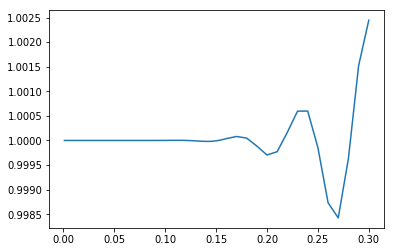

In [1382]:
l=1
#plt.plot(common.k, pyPslin[l]/pyPs0lin[l])
#plt.plot(common.k, pyPstlin[l]/pyPs0lin[l])

plt.plot(common.k, pyPs[l]/pyPs0[l])
#plt.plot(common.k, pyPst[l]/pyPs0t[l])

#plt.plot(common.k, pyPs0t[l]/pyPs0[l])

(0.995, 1.005)

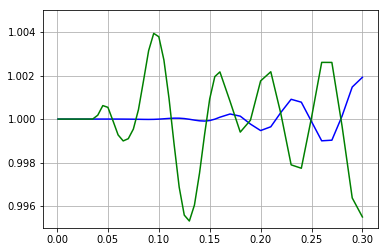

In [1376]:
plt.plot(k0, pyPst[0]/pyPs[0], color = 'b', label = 'mono')
plt.plot(k0, pyPst[1]/pyPs[1], color = 'g', label = 'quad')
plt.grid()
plt.ylim(0.995, 1.005)

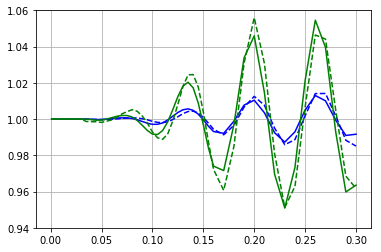

In [1370]:
for l,c  in zip([0, 1], ['b', 'g']):
    plt.plot(k0, psr[l]/ps0[l], '--', color = c)
    #plt.plot(common.k, pyPs[l]/pyPs0[l], color = c)
    plt.plot(common.k, pyPst[l]/pyPs0t[l], color = c)
if l is 0: plt.ylim(1-.015, 1.015)
else: plt.ylim(1-.06, 1.06)
plt.grid()
#plt.ylim(0.98, 1.02)
#plt.legend()
#plt.savefig('output/pyvsc++_ratio-res-nores.pdf', bbox_inch='tight')

(0.98, 1.02)

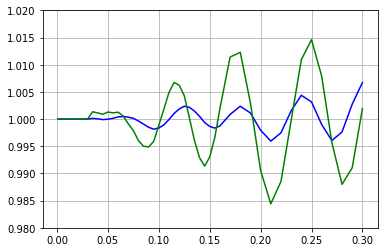

In [1377]:
plt.plot(k0, pyPst[0]/psr[0], color = 'b', label = 'mono')
plt.plot(k0, pyPst[1]/psr[1], color = 'g', label = 'quad')
plt.grid()
plt.ylim(0.98, 1.02)
#plt.legend()
#plt.savefig('output/pyvsc++res.pdf', bbox_inch='tight')

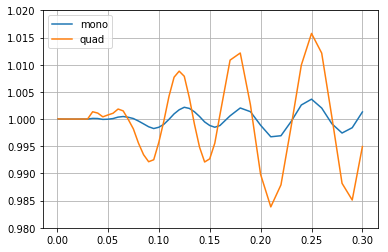

In [714]:
plt.plot(k0, pyPs[0]/psr[0], label = 'mono')
plt.plot(k0, pyPs[1]/psr[1], label = 'quad')
plt.grid()
plt.ylim(0.98, 1.02)
plt.legend()
plt.savefig('output/pyvsc++res.pdf', bbox_inch='tight')

In [545]:
knl = 1.
km = 1.
nd = 4e-5

fitCMASS = {'b1': 2.22, 'b2': 1.2 / np.sqrt(2.), 'b3': 0.1, 'b4': 1.2 / np.sqrt(2.),
        'b5': 0.4, 'b6': -7.7, 'b7': 0., 'b8': 0.0,
        'b9': 0., 'b10': -3.7, 'b11': 0,
        'e1': 0, 'e2': 0}

fitGUIDO = {'b1': 2.4, 'b2': 1.4 / np.sqrt(2.), 'b3': 0., 'b4': 1.4 / np.sqrt(2.),
        'b5': 0., 'b6': -6., 'b7': 0., 'b8': 0.02,
        'b9': 0., 'b10': -2.8, 'b11': 0,
        'e1': 0, 'e2': 0}

def get_bias(d_fit):
    return np.array([0, 1., d_fit['b1'], d_fit['b1']**2, 
                      #0, 0., 0., 0., 
                      1., d_fit['b1'], d_fit['b2'], d_fit['b3'], d_fit['b4'],
                      d_fit['b1']**2, d_fit['b1'] * d_fit['b2'], d_fit['b1'] * d_fit['b3'], d_fit['b1'] * d_fit['b4'],
                      d_fit['b2']**2, d_fit['b2'] * d_fit['b4'], d_fit['b4']**2,
                      d_fit['b1'] * d_fit['b5'] / knl**2, d_fit['b1'] * d_fit['b6'] / km**2,
                      d_fit['b1'] * d_fit['b7'] / km**2, d_fit['b5'] / knl**2, d_fit['b6'] / km**2, d_fit['b7'] / km**2])

def get_PSbias(name, dfit, Nl=2):
    pbird = np.loadtxt(name, comments = '#')
    k = pbird[:, 0].reshape(Nl,-1)[0]
    pbird = pbird.reshape(Nl, len(k), pbird.shape[1])
    v = get_bias(dfit)
    #v = np.array([0, 1., dfit['b1'], dfit['b1']**2] + 18*[0])
    PS = np.einsum('c,mkc->mk', v, pbird)
    PS[0] = PS[0] + dfit['b8'] / nd + dfit['b9'] / nd / km**2 * k**2
    PS[1] = PS[1] #+ dfit['b10'] / nd / km**2 * k**2
    return k, PS

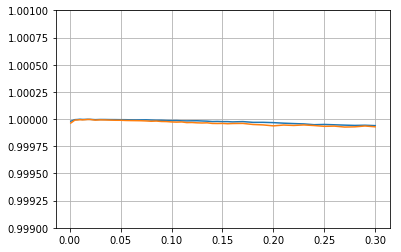

In [512]:
fitTEST = {'b1': 2.3, 'b2': 0.8, 'b3': 0.2, 'b4': 0.8,
        'b5': 0.4, 'b6': -7., 'b7': 0., 'b8': 0.0,
        'b9': 0., 'b10': 0., 'b11': 0,
        'e1': 0, 'e2': 0}

k0, ps0 = get_PSbias('output/test/PowerSpectraNoResum.dat', fitTEST, Nl=2)
kr, psr = get_PSbias('output/test/PowerSpectra.dat', fitTEST, Nl=2)

plt.plot(k0, ps0[0]/(bird.Ps[0,0]+bird.Ps[1,0]), label = 'mono')
plt.plot(k0, ps0[1]/(bird.Ps[0,1]+bird.Ps[1,1]), label = 'quad')
plt.ylim(0.999, 1.001)
plt.grid()

In [1346]:
test = np.zeros((10, 11, 15))
sh = test.shape
sh[-1] = 6

TypeError: 'tuple' object does not support item assignment